In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os
import sys

print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "6"

freeman-v100-2.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [78]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x[..., None]
        x = nn.Dense(features=32)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=32)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=1)(x)
        return x[..., 0]

mlp = MLP()

In [128]:
def f1(x):
    return .5*x+1
def f2(x):
    return .5*x+.7

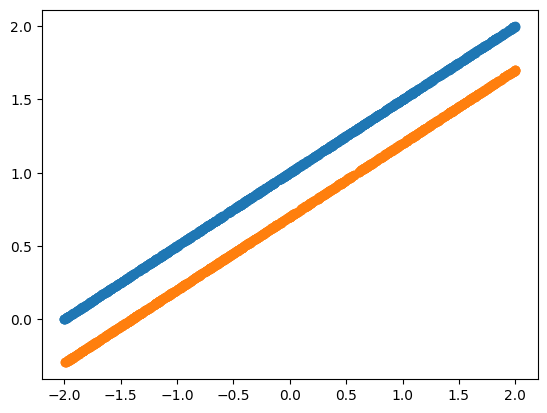

In [129]:
x1 = jax.random.uniform(jax.random.PRNGKey(0), (1000,), minval=-2, maxval=2)
y1 = f1(x1)
x2 = jax.random.uniform(jax.random.PRNGKey(1), (1000,), minval=-2, maxval=2)
y2 = f2(x2)
x2_small, y2_small = x2[:4], y2[:4]
plt.scatter(x1, y1)
plt.scatter(x2, y2)

In [130]:
def plot_nn_func(params, **kwargs):
    x = jnp.linspace(-2, 2, 100)
    y = jax.vmap(mlp.apply, in_axes=(None, 0))(params, x[:, None])
    plt.plot(x, y, **kwargs)

In [131]:
def loss_fn(params, batch):
    pred = jax.vmap(mlp.apply, in_axes=(None, 0))(params, batch['x'])
    return jnp.mean((pred - batch['y']) ** 2)

@jax.jit
def train_step(train_state, batch):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(train_state.params, batch)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, loss

def sample_batch(rng, x, y, bs=32):
    idx = jax.random.randint(rng, (bs,), minval=0, maxval=len(x))
    return dict(x=x[idx], y=y[idx])

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.062123526


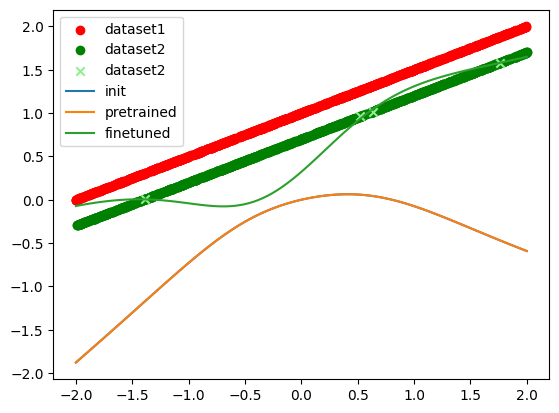

In [134]:
rng = jax.random.PRNGKey(0)

rng, _rng = split(rng)
params_init = mlp.init(_rng, jnp.zeros(1))

plt.scatter(x1, y1, c='r', label='dataset1', marker='o')
plt.scatter(x2, y2, c='g', label='dataset2', marker='o')
plt.scatter(x2_small, y2_small, c='lightgreen', label='dataset2', marker='x')
plot_nn_func(params_init, label='init')

opt = optax.adam(learning_rate=3e-4)
train_state = TrainState.create(apply_fn=mlp.apply, params=params_init, tx=opt)

for i in tqdm(range(0)):
    rng, _rng = split(rng)
    batch = sample_batch(_rng, x1, y1, bs=32)
    train_state, loss = train_step(train_state, batch)
plot_nn_func(train_state.params, label='pretrained')


for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    batch = sample_batch(_rng, x2_small, y2_small, bs=32)
    train_state, loss = train_step(train_state, batch)

plot_nn_func(train_state.params, label='finetuned')

print(loss_fn(train_state.params, dict(x=x2, y=y2)))

plt.legend()

In [133]:
0.18103093

0.18103093

In [ ]:
0.4033127